In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


# Importing Libraries

In [2]:
#importing the required libraries
import os
from PIL import Image
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

from glob import glob
import zipfile
import shutil

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Processing

In [3]:
# Extracting the data 
path_to_zip_file = "/kaggle/input/carvana-image-masking-challenge/train.zip"
directory_to_extract_to = "/kaggle/working/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
    
path_to_zip_file = "/kaggle/input/carvana-image-masking-challenge/train_masks.zip"
directory_to_extract_to = "/kaggle/working/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
#Preparing the train and val datasets
os.mkdir('/kaggle/working/val')
os.mkdir('/kaggle/working/val_masks')

#taking the first 1520 train images as val images
for file in sorted(os.listdir('/kaggle/working/train'))[:1520]:
  shutil.move('/kaggle/working/train/' + file, '/kaggle/working/val')

for file in sorted(os.listdir('/kaggle/working/train_masks'))[:1520]:
  shutil.move('/kaggle/working/train_masks/' + file, '/kaggle/working/val_masks')

In [5]:
train_img_path = ['/kaggle/working/train/' + i for i in sorted(os.listdir('/kaggle/working/train'))]
train_mask_path = ['/kaggle/working/train_masks/' + i for i in sorted(os.listdir('/kaggle/working/train_masks'))]
val_img_path = ['/kaggle/working/val/' + i for i in sorted(os.listdir('/kaggle/working/val'))]
val_mask_path = ['/kaggle/working/val_masks/' + i for i in sorted(os.listdir('/kaggle/working/val_masks'))]

print("No: of Train images:", len(train_img_path))
print("No: of Train masks:", len(train_mask_path))
print("No: of Val images:", len(val_img_path))
print("No: of Val masks:", len(val_mask_path))

No: of Train images: 3568
No: of Train masks: 3568
No: of Val images: 1520
No: of Val masks: 1520


In [6]:
os.mkdir('/kaggle/working/saved_images')
#folder for saving the predicted masks

# Visualizing a Image along with its Mask

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


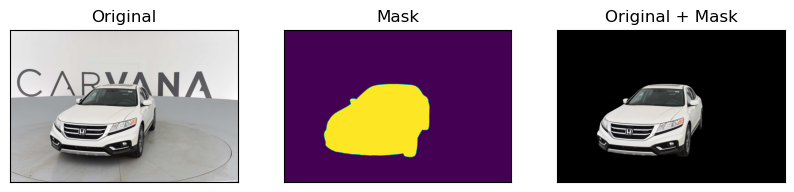

In [7]:
#Show a random car with its mask
k = int(np.ceil(np.random.random()*len(train_img_path)))

img = cv2.imread(train_img_path[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = np.asarray(Image.open(train_mask_path[k]))
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype))

#plotting
fig = plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img)
#remove ticks for pictures
plt.xticks([])
plt.yticks([])
plt.title("Original")

plt.subplot(132)
plt.imshow(mask)
#remove ticks for pictures
plt.xticks([])
plt.yticks([])
plt.title("Mask")

plt.subplot(133)
plt.imshow(img_masked)
#remove ticks for pictures
plt.xticks([])
plt.yticks([])
plt.title("Original + Mask")

plt.show()

# Take a look at the image masks

0.2008504953076121


([], [])

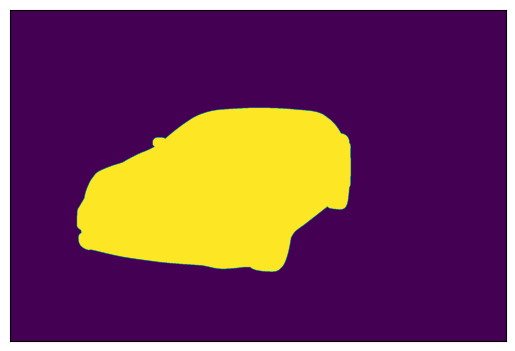

In [8]:
#select any random train image and its corresponding mask
k = int(np.ceil(np.random.random()*len(train_img_path)))

img = cv2.imread(train_img_path[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = np.asarray(Image.open(train_mask_path[k]))

area = mask.shape[0] *mask.shape[1] 
masked = sum(map(sum, mask))
print(masked/area) #see the area of mask in the whole image

plt.imshow(mask)
plt.xticks([])
plt.yticks([])

Clearly the masked area is only 20% percent of the picture while the rest is background. quite an surprising finding looking at the picture itself.

In [9]:
#Let's look at the whole train set of masks:

def calculate_mask_background_ratio(mask):
    masked_area = sum(map(sum, mask))
    return masked_area/(mask.shape[0] *mask.shape[1])

all_masks = []
for path in train_mask_path:
    mask = np.asarray(Image.open(path))
    all_masks.append(mask) 
masks_ratio = [calculate_mask_background_ratio(mask) for mask in all_masks]

print('The masked area on average represents {:.2f}% of the picture.'.format(100*np.mean(masks_ratio)))

The masked area on average represents 21.28% of the picture.


The masked area of the train masks on average represents 21.28% of the train image.

# UNET Model

In [10]:
class DoubleConv(nn.Module): #class for 2 conv layers
  def __init__(self, in_channels, out_channels):#input is passed through 2 conv layers in the architecture
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), #3x3 conv
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

class UNET(nn.Module):
  def __init__(
      self, in_channels=3, out_channels=1, features=[64,128,256,512],
  ):

    super(UNET, self).__init__()
    self.ups = nn.ModuleList()    # list to save the conv layers in decoder part
    self.downs = nn.ModuleList()  # list to save the conv layers in encoder part
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #------------Down/Encoder part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature
    # So self.downs =[DoubleConv(3,64),DoubleConv(64,128),DoubleConv(128,256),DoubleConv(256,512) ]

    #------------bottleneck part where DoubleConv(512,1024) happens
    self.bottleneck = DoubleConv(features[-1], features[-1]*2)

     #-------------Up/Decoder part of UNET
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))

      self.ups.append(DoubleConv(feature*2, feature))

        #So self.ups =[ConvTranspose2d(1024,512),DoubleConv(1024,512),
        #            ConvTranspose2d(512,256),DoubleConv(512,256),
        #           ConvTranspose2d(256,128),DoubleConv(256,128),
        #            ConvTranspose2d(128,64),DoubleConv(128,64)]
    
    #----final conv layer to get the o/p segmentation map with channels 1 for carvana segmentation
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x) # storing the resultant after double conv so that we can add them in decoder part
      x = self.pool(x) #pooling

    x = self.bottleneck(x)

    #We have skip_connections=resultant of [DoubleConv(3,64),DoubleConv(64,128),DoubleConv(128,256),DoubleConv(256,512)]
    #we need to add these from last i.e, DoubleConv(256,512) layer is added to the 1st upconv layer(1024)
    # so we reverse skip_connections
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups),2):
      x = self.ups[idx](x) #perform ConvTranspose2d
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape: #if i/p:161x161-->80x80 and up part makes it 160x160 which are not equal
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)#adding the skip connections
      x = self.ups[idx+1](concat_skip)#perform DoubleConv

    return self.final_conv(x)

def test():
  x = torch.rand((3,1,161,161))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape


if __name__ == '__main__':
  test()



/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Prepare Data

In [11]:
class CarvanaDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir #path of images(i/p)
    self.mask_dir  = mask_dir  #path of masks(target)
    self.transform = transform #applying transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    #training set masks are in .gif format..so convert then into .jpg
    mask_path = os.path.join(self.mask_dir, self.images[index]).replace(".jpg", "_mask.gif")
    
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask



# Training the Model

In [12]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 480
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = '/kaggle/working/train'
TRAIN_MASK_DIR = '/kaggle/working/train_masks'
VAL_IMG_DIR = '/kaggle/working/val'
VAL_MASK_DIR = '/kaggle/working/val_masks'

In [13]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving Checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading Checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
  train_ds = CarvanaDataset(
      image_dir=train_dir,
      mask_dir=train_maskdir,
      transform=train_transform,
  )

  train_loader = DataLoader(
      train_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=True,
  )

  val_ds = CarvanaDataset(
      image_dir=val_dir,
      mask_dir=val_maskdir,
      transform=val_transform,

  )

  val_loader = DataLoader(
      val_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=False,
  )

  return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels = 0
  model.eval()
  dice_score=0.0
    
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2* (preds*y).sum()) / (
          (preds + y).sum() + 1e-8
      )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )

    print(f"Dice Score: {dice_score/len(loader)}")

    model.train()


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")


    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")



In [14]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    # check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )


if __name__ == "__main__":
    main()

100%|██████████| 446/446 [03:29<00:00,  2.13it/s, loss=0.0964]


=> Saving Checkpoint
Got 228603605/233472000 with acc 97.91
Dice Score: 0.9517869353294373


100%|██████████| 446/446 [03:14<00:00,  2.30it/s, loss=0.0279]


=> Saving Checkpoint
Got 230923542/233472000 with acc 98.91
Dice Score: 0.9737224578857422


100%|██████████| 446/446 [03:12<00:00,  2.31it/s, loss=0.0235]


=> Saving Checkpoint
Got 231061901/233472000 with acc 98.97
Dice Score: 0.9754621386528015


Accuracy achieved is **98.97%** and Dice Coefficient of **97.54%**

# Training the model for another 10 epochs

In [15]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 1
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 480
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = '/kaggle/working/train'
TRAIN_MASK_DIR = '/kaggle/working/train_masks'
VAL_IMG_DIR = '/kaggle/working/val'
VAL_MASK_DIR = '/kaggle/working/val_masks'

In [16]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    #applying augmentations
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()  #BCE loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )


if __name__ == "__main__":
    main()

=> Loading Checkpoint
Got 231061903/233472000 with acc 98.97
Dice Score: 0.9754025340080261


100%|██████████| 223/223 [03:27<00:00,  1.07it/s, loss=0.0564]


=> Saving Checkpoint
Got 231270768/233472000 with acc 99.06
Dice Score: 0.9775727391242981


100%|██████████| 223/223 [03:23<00:00,  1.10it/s, loss=0.0225]


=> Saving Checkpoint
Got 231437014/233472000 with acc 99.13
Dice Score: 0.9789367318153381


100%|██████████| 223/223 [03:22<00:00,  1.10it/s, loss=0.0305]


=> Saving Checkpoint
Got 231357626/233472000 with acc 99.09
Dice Score: 0.9783735275268555


100%|██████████| 223/223 [03:20<00:00,  1.11it/s, loss=0.0167]


=> Saving Checkpoint
Got 231824464/233472000 with acc 99.29
Dice Score: 0.9830468893051147


100%|██████████| 223/223 [03:20<00:00,  1.11it/s, loss=0.0154]


=> Saving Checkpoint
Got 231897987/233472000 with acc 99.33
Dice Score: 0.983819305896759


100%|██████████| 223/223 [03:19<00:00,  1.12it/s, loss=0.0145]


=> Saving Checkpoint
Got 232119420/233472000 with acc 99.42
Dice Score: 0.9860567450523376


100%|██████████| 223/223 [03:20<00:00,  1.11it/s, loss=0.016]


=> Saving Checkpoint
Got 232147363/233472000 with acc 99.43
Dice Score: 0.9863324165344238


100%|██████████| 223/223 [03:17<00:00,  1.13it/s, loss=0.0156]


=> Saving Checkpoint
Got 232351284/233472000 with acc 99.52
Dice Score: 0.9883544445037842


100%|██████████| 223/223 [03:17<00:00,  1.13it/s, loss=0.0166]


=> Saving Checkpoint
Got 231444369/233472000 with acc 99.13
Dice Score: 0.9791768789291382


100%|██████████| 223/223 [03:18<00:00,  1.12it/s, loss=0.0148]


=> Saving Checkpoint
Got 232182358/233472000 with acc 99.45
Dice Score: 0.9867129325866699


We can see that the model achieved Accuracy of **99.45** and Dice Coefficient of **98.67%**